In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression,make_classification

In [43]:
df = pd.read_csv("./archive/compas-scores-two-years-violent.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


In [44]:
selected_columns = ['sex','age', 'race', 'juv_fel_count','decile_score',
                    'juv_misd_count','juv_other_count', 'priors_count',
                    'c_jail_in', 'c_jail_out','c_charge_degree', "is_recid", 
                    'is_violent_recid']

In [45]:
df_selected = df.loc[:, selected_columns]
df_selected.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_jail_in,c_jail_out,c_charge_degree,is_recid,is_violent_recid
0,Male,69,Other,0,1,0,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,F,0,0
1,Male,34,African-American,0,3,0,0,0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,1,1
2,Male,23,African-American,0,8,1,0,1,NaN,NaN,F,0,0
3,Male,43,Other,0,1,0,0,2,NaN,NaN,F,0,0
4,Male,44,Other,0,1,0,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,M,0,0


In [46]:
print(df_selected['race'].unique())
df_selected['race'] = df_selected['race'].map({'Other':0, 'African-American':1,
                                                'Caucasian':2, 'Hispanic':3, 'Asian':4,
                                                 'Native American':5})

['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']


In [47]:
df_selected['c_charge_degree'] = df_selected['c_charge_degree'].map({'F':1,'M':0})

In [48]:
df_selected['sex'] = df_selected['sex'].map({'Male': 1,'Female': 0}).fillna(-1)
print(df_selected['sex'])

0       1
1       1
2       1
3       1
4       1
       ..
4738    1
4739    1
4740    1
4741    1
4742    0
Name: sex, Length: 4743, dtype: int64


In [49]:
df_selected_corr = df_selected.drop(columns=['c_jail_in', 'c_jail_out'])
df_selected_corr.count()

sex                 4743
age                 4743
race                4743
juv_fel_count       4743
decile_score        4743
juv_misd_count      4743
juv_other_count     4743
priors_count        4743
c_charge_degree     4743
is_recid            4743
is_violent_recid    4743
dtype: int64

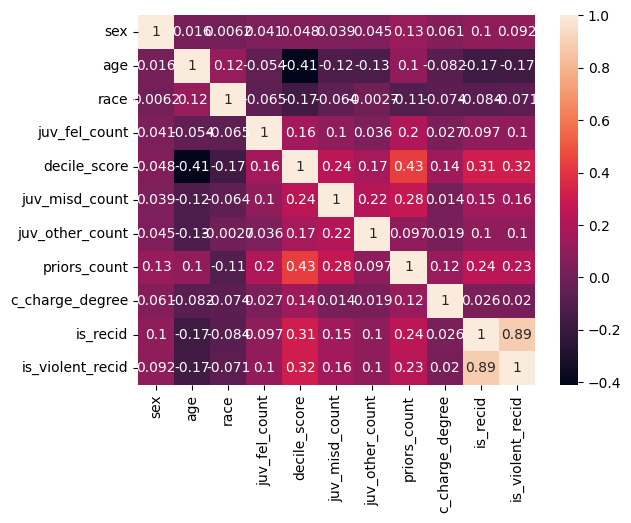

In [50]:
corr = df_selected_corr.corr()
ax = sns.heatmap(corr, annot=True)

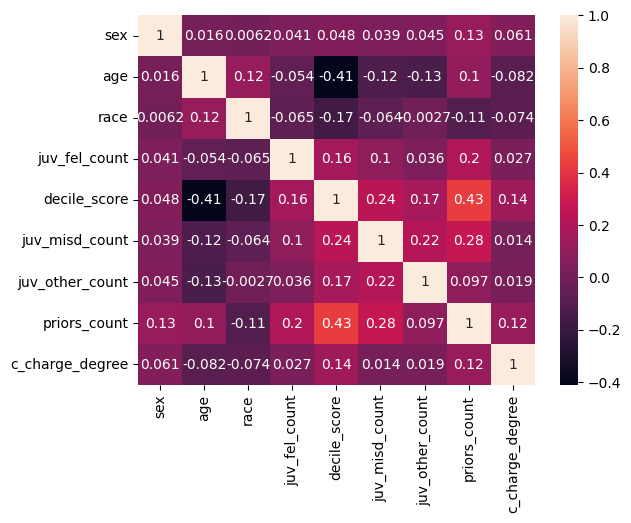

In [86]:
df_selected_train = df_selected_corr.drop(columns=['is_recid', 'is_violent_recid'])
target = df_selected_corr['is_recid']
corr = df_selected_train.corr()
ax = sns.heatmap(corr, annot=True)


In [52]:
df_selected_train.count()

sex                4743
age                4743
race               4743
juv_fel_count      4743
decile_score       4743
juv_misd_count     4743
juv_other_count    4743
priors_count       4743
c_charge_degree    4743
dtype: int64

In [57]:
df_selected_train['decile_score'].unique()
df_selected_train = df_selected_train[df_selected_train['decile_score'] != -1]


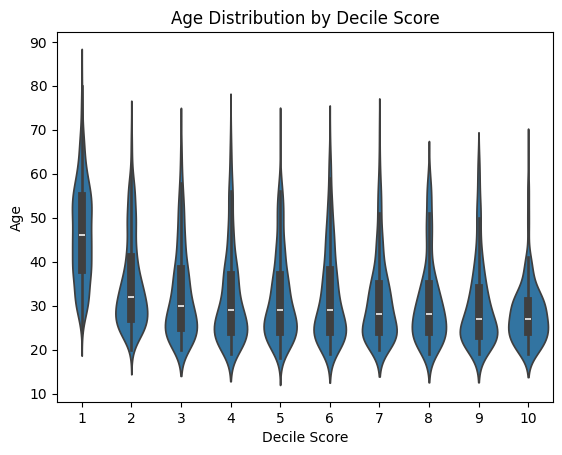

In [54]:
sns.violinplot(x="decile_score", y="age", data=df_selected_train)
plt.xlabel("Decile Score")
plt.ylabel("Age")
plt.title("Age Distribution by Decile Score")
plt.show()


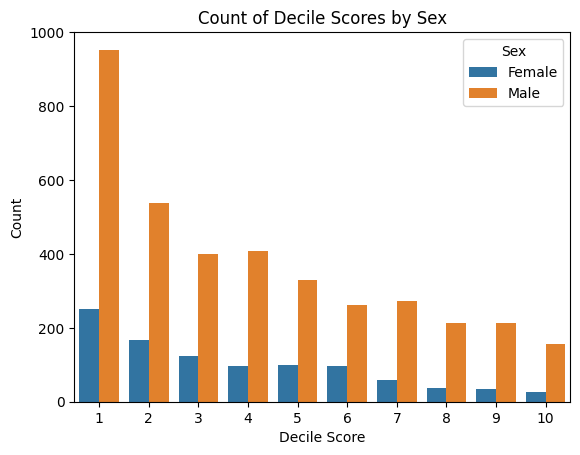

In [59]:
sns.countplot(x="decile_score", hue="sex", data=df_selected_train)
plt.xlabel("Decile Score")
plt.ylabel("Count")
plt.title("Count of Decile Scores by Sex")
plt.legend(title="Sex", labels=["Female", "Male"])
plt.show()

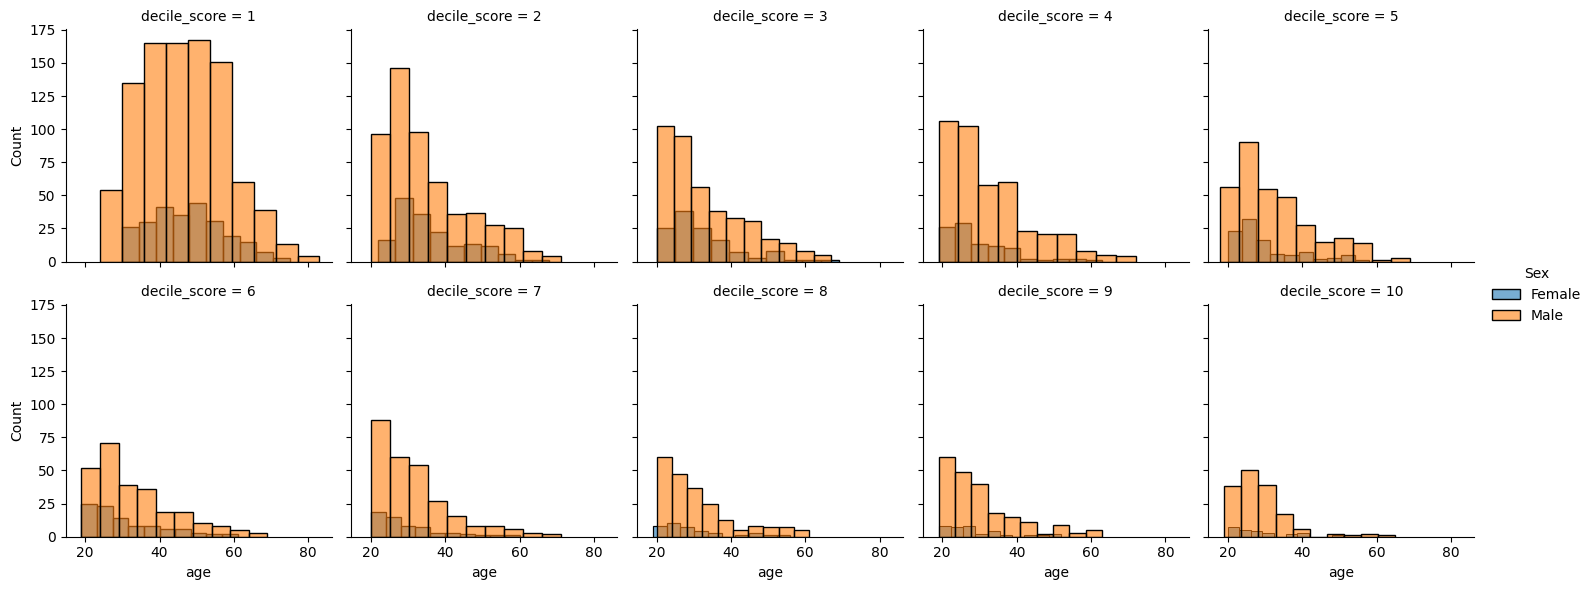

In [63]:
g = sns.FacetGrid(df_selected_train, col="decile_score", hue="sex", col_wrap=5, height=3, sharex=True, sharey=True)
g.map(sns.histplot, "age", bins=10, alpha=0.6)
g.add_legend(title="Sex", labels=["Female", "Male"])
plt.show()

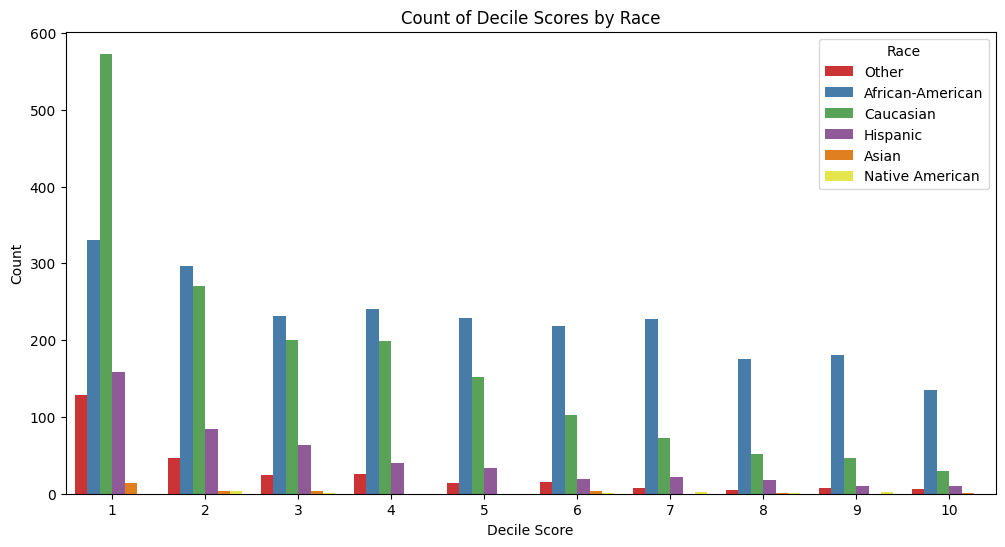

In [68]:
plt.figure(figsize=(12, 6))
sns.countplot(x="decile_score", hue="race", data=df_selected_train, palette="Set1")

plt.xlabel("Decile Score")
plt.ylabel("Count")
plt.title("Count of Decile Scores by Race")
plt.legend(title="Race", labels=['Other', 'African-American','Caucasian', 'Hispanic', 'Asian',
                                'Native American'])
plt.show()


/tmp/ipykernel_1410/2143878489.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="race", y="decile_score", data=df_selected_train, estimator=np.mean, palette="Set1")


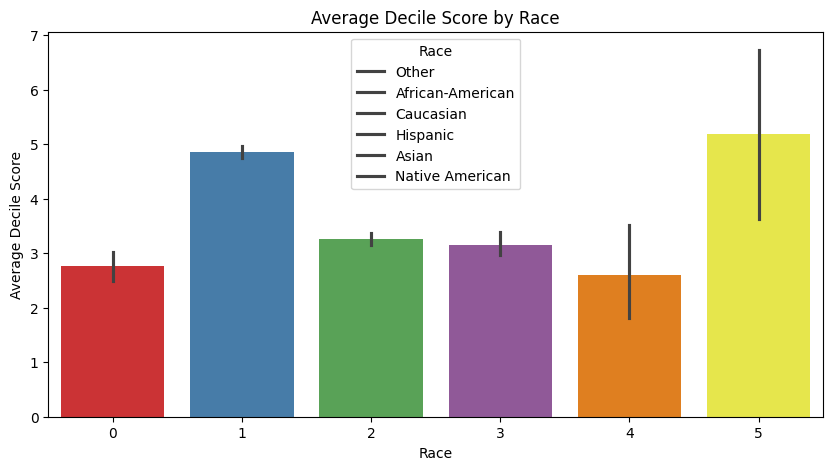

In [78]:
plt.figure(figsize=(10, 5))
sns.barplot(x="race", y="decile_score", data=df_selected_train, estimator=np.mean, palette="Set1")

plt.xlabel("Race")
plt.ylabel("Average Decile Score")
plt.legend(title="Race", labels=['Other', 'African-American','Caucasian', 'Hispanic', 'Asian',
                                'Native American'])
plt.title("Average Decile Score by Race")
plt.show()


In [95]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_selected_train, target, test_size=0.2, random_state=22)

# Apply SMOTE to training data
smote = SMOTE(sampling_strategy="auto", random_state=42)  # "auto" balances classes equally
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train model on balanced dataset
model = RandomForestClassifier(n_estimators=100, random_state=22)
model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=22)

In [97]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability of "recid" (class 1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed Performance Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.70
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.76      0.80       757
           1       0.33      0.47      0.39       192

    accuracy                           0.70       949
   macro avg       0.59      0.61      0.59       949
weighted avg       0.74      0.70      0.72       949

Confusion Matrix:
 [[573 184]
 [102  90]]


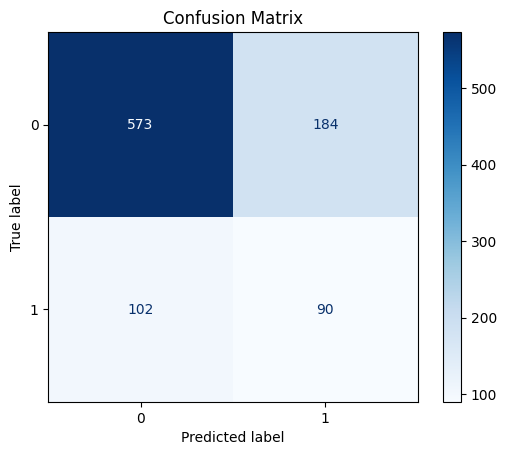

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [116]:

# Get probability predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Adjust threshold (e.g., 0.3)
new_threshold = 0.4
y_pred_adjusted = np.where(y_pred_proba >= new_threshold, 1, 0)

# Check new performance
print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       0.86      0.69      0.76       757
           1       0.31      0.55      0.40       192

    accuracy                           0.66       949
   macro avg       0.58      0.62      0.58       949
weighted avg       0.75      0.66      0.69       949



In [114]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       757
           1       0.34      0.47      0.39       192

    accuracy                           0.71       949
   macro avg       0.59      0.62      0.60       949
weighted avg       0.75      0.71      0.72       949



In [125]:
import lime
import lime.lime_tabular
import numpy as np

# Create a LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X_train.columns, 
    class_names=['Non-Recid', 'Recid'], 
    mode='classification'
)

# Choose an instance to explain (e.g., the first test sample)
i = 3
exp = explainer.explain_instance(X_test.iloc[i].values, model.predict_proba)

# Show the explanation
exp.show_in_notebook()


/home/raul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/home/raul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/raul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/raul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/raul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/raul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with featur

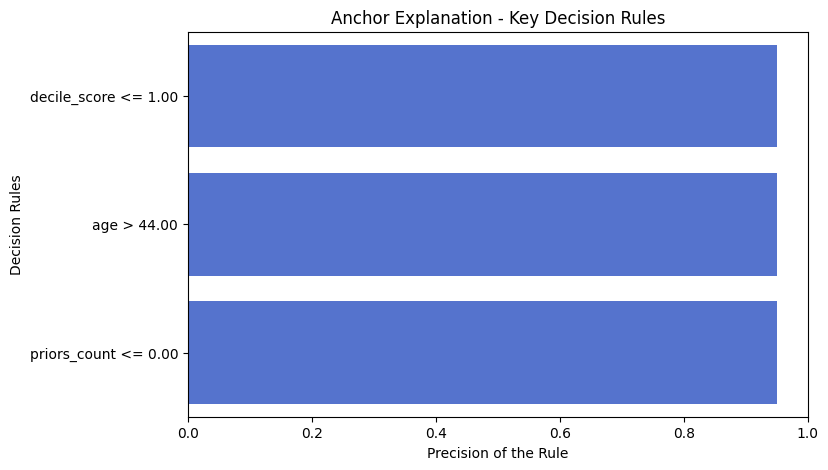

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from alibi.explainers import AnchorTabular

# Convert to numpy arrays
X_train_np = X_train.values
X_test_np = X_test.values

# Define predictor function
predictor = lambda x: model.predict(x)

# Create and fit the explainer
explainer = AnchorTabular(predictor, feature_names=X_train.columns.tolist())
explainer.fit(X_train_np)

# Explain a sample (e.g., first test instance)
i = 0
explanation = explainer.explain(X_test_np[i])

# Extract Anchor rules and precision
rules_list = explanation.data['anchor']  # Extract rules correctly
precision = explanation.data['precision']  # Precision of rule

# Convert rules into a readable format for visualization
rules_text = [f"{rule}" for rule in rules_list]  # Ensure proper formatting

# Plot the rules as a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=[precision] * len(rules_text), y=rules_text, color="royalblue")

plt.xlabel("Precision of the Rule")
plt.ylabel("Decision Rules")
plt.title("Anchor Explanation - Key Decision Rules")
plt.xlim(0, 1)  # Precision is between 0 and 1
plt.show()


/home/raul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


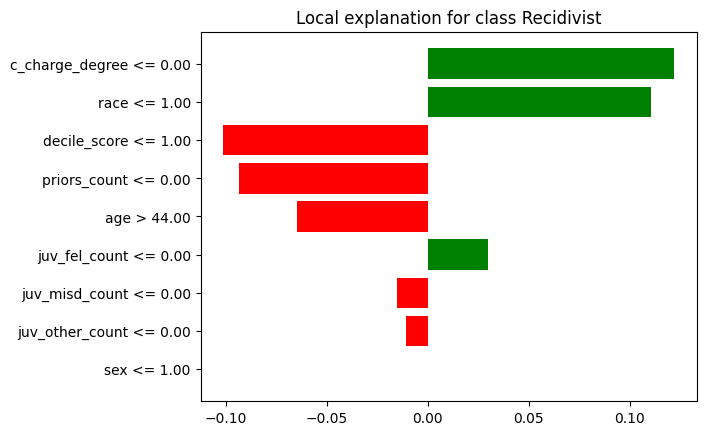

In [126]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Define LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, 
    feature_names=X_train.columns.tolist(), 
    class_names=["Not Recidivist", "Recidivist"], 
    mode="classification"
)

# Explain a sample (same index as Anchor explanation)
i = 0
exp = explainer_lime.explain_instance(X_test.values[i], model.predict_proba)

# Visualize explanation
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()
plt.show()


In [128]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


In [132]:
X_test = pd.DataFrame(X_test, columns=df_selected_train.columns)  # Ensure columns are labeled
print (X_test)

      sex  age  race  juv_fel_count  decile_score  juv_misd_count  \
3408    0   52     1              0             1               0   
2841    1   26     2              0             4               0   
4216    1   42     2              0             1               0   
2917    1   31     1              0             2               0   
247     1   24     2              0             4               0   
...   ...  ...   ...            ...           ...             ...   
3398    1   55     3              0             1               0   
3985    1   35     2              0             4               0   
4429    0   31     1              0             8               0   
3335    0   34     0              0             1               0   
2477    1   56     1              0             4               0   

      juv_other_count  priors_count  c_charge_degree  
3408                0             0                0  
2841                0             4                1  
4216  

In [137]:
print(X_test.shape)          # Shape of input data
print(shap_values.shape)     # Shape of SHAP values
shap_values_selected = shap_values[..., 1]  # Selects only the 2nd dimension
print(shap_values_selected.shape)     # Shape of SHAP values



(949, 9)
(949, 9, 2)
(949, 9)


In [138]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)


ExactExplainer explainer: 950it [02:15,  7.03it/s]                         


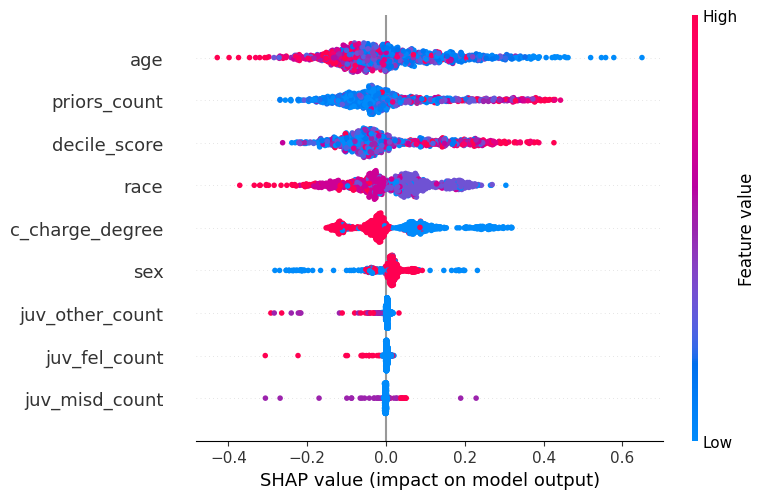

In [139]:
shap.summary_plot(shap_values, X_test)
